In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import mne
import random
from sklearn.metrics import classification_report

In [88]:
MDD_dataset_Filenames = os.listdir('./data/MDD')
H_dataset_Filenames = os.listdir('./data/H')
MDD_dataset_list = []
H_dataset_list = []

for filename in MDD_dataset_Filenames:
    data = mne.io.read_raw_edf('./dataset/EC/' + str(filename))
    MDD_dataset_list.append(data)  
    
for filename in H_dataset_Filenames:
    data = mne.io.read_raw_edf('./dataset/EC/' + str(filename))
    H_dataset_list.append(data)  



Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S1 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S10 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S11 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S12 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S13 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\python\study\4월3주\depression\dataset\EC\MDD S14 EC.edf...
EDF file detected
Setting channel 

In [89]:
MDD_dataframe_list = [] #MDD 환자의 데이터프레임 리스트
H_dataframe_list = [] #건강한 사람의 데이터프레임 리스트
for raw in MDD_dataset_list:
    raw_data = raw.get_data(return_times=True)
    channels = raw.ch_names
    T_data = np.transpose(raw_data[0])
    time = np.transpose(raw_data[1])
    temp = pd.DataFrame(T_data, columns = channels, index = time)
    MDD_dataframe_list.append(temp)
    
for raw in H_dataset_list:
    raw_data = raw.get_data(return_times=True)
    channels = raw.ch_names
    T_data = np.transpose(raw_data[0])
    time = np.transpose(raw_data[1])
    temp = pd.DataFrame(T_data, columns = channels, index = time)
    H_dataframe_list.append(temp)

MDD_dataframe_list[23].rename(columns = {'E F3-Ref': 'F3'}, inplace = True)

In [90]:
X = {}
y = []
for i in range(len(MDD_dataframe_list)):
    a = MDD_dataframe_list[i]
    #데이터 클린징
    a.F3 = a.F3[a.F3 > -0.0005]
    a = a.fillna(method='ffill')
    fft = np.fft.fft(a['F3'])
    fft = np.abs(fft)
    X[i] = fft
    y.append(1)
    
for i in range(30, 30+len(H_dataframe_list)):
    a = H_dataframe_list[30-i]
    a.rename(columns = {'EEG F3-LE' : 'F3'}, inplace = True)
    #데이터 클린징
    a.F3 = a.F3[a.F3 > -0.0005]
    a = a.fillna(method='ffill')
    fft = np.fft.fft(a['F3'])
    fft = np.abs(fft)
    X[i] = fft
    y.append(0)
    
X = pd.DataFrame.from_dict(X, orient='index')
X['target'] = y

In [91]:
X = X.fillna(0)

In [92]:
# 타겟 컬럼과 특징 컬럼 정의

target_col = 'target'
target = X[target_col]
features = X[X.columns.difference(['target'])]


In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5)

In [94]:
from sklearn.svm import SVC
#SVM Model
svm_linear = SVC(kernel='linear', random_state=0)
svm_linear.fit(X_train, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [95]:
#SVM 선형 평가
print("테스트 세트 예측 : ", svm_linear.predict(X_test))
print("테스트 세트 정확도 : ", svm_linear.score(X_test, y_test))

y_pred = svm_linear.predict(X_test)
print(classification_report(y_test, y_pred))


테스트 세트 예측 :  [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
테스트 세트 정확도 :  0.6956521739130435
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.68      1.00      0.81        15

    accuracy                           0.70        23
   macro avg       0.84      0.56      0.52        23
weighted avg       0.79      0.70      0.61        23



In [96]:
from sklearn.metrics import roc_curve
from keras import models
from keras import layers
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [97]:
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (77312,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m])

history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.2)

Train on 17 samples, validate on 5 samples
Epoch 1/10
17/17 [==============================] - 7s 403ms/step - loss: 0.6928 - accuracy: 0.7059 - recall_m: 0.8182 - precision_m: 0.7500 - f1_m: 0.7826 - val_loss: 0.6019 - val_accuracy: 0.8000 - val_recall_m: 1.0000 - val_precision_m: 0.8000 - val_f1_m: 0.8889
Epoch 2/10
17/17 [==============================] - 1s 56ms/step - loss: 0.6042 - accuracy: 0.6471 - recall_m: 1.0000 - precision_m: 0.6471 - f1_m: 0.7857 - val_loss: 0.4779 - val_accuracy: 0.8000 - val_recall_m: 1.0000 - val_precision_m: 0.8000 - val_f1_m: 0.8889
Epoch 3/10
17/17 [==============================] - 0s 19ms/step - loss: 0.5144 - accuracy: 0.6471 - recall_m: 1.0000 - precision_m: 0.6471 - f1_m: 0.7857 - val_loss: 0.4348 - val_accuracy: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 4/10
17/17 [==============================] - 0s 18ms/step - loss: 0.4637 - accuracy: 0.8824 - recall_m: 1.0000 - precision_m: 0.8462 - f1_m: 0.9167 - val_

In [98]:
results = model.evaluate(X_test, y_test)
results

23/23 [==============================] - 0s 11ms/step


[0.5780936479568481,
 0.9130434989929199,
 1.0,
 0.8823529481887817,
 0.9374999403953552]

In [99]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 64)                4948032   
_________________________________________________________________
dense_134 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 65        
Total params: 4,952,257
Trainable params: 4,952,257
Non-trainable params: 0
_________________________________________________________________


In [100]:
mse = model.evaluate(X_test, y_test, batch_size=1)
print("mse{}".format(mse))


23/23 [==============================] - 1s 46ms/step - ETA: 0s
mse[0.5780934561043978, 0.9130434989929199, 0.6521738767623901, 0.6521738767623901, 0.6521738767623901]


In [101]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
print(fpr_keras, tpr_keras)


[0.    0.125 0.125 1.   ] [0. 0. 1. 1.]


In [102]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.875


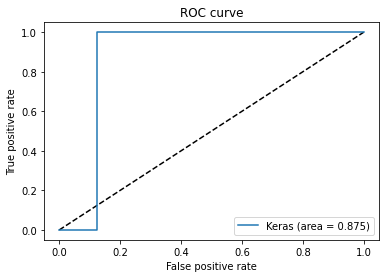

In [103]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [104]:

accuracy_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=3)
for train, test in kfold.split(features, target):
    k_model = models.Sequential()
    k_model.add(layers.Dense(64, activation = 'relu', input_shape = (77312,)))
    k_model.add(layers.Dense(64, activation = 'relu'))
    k_model.add(layers.Dense(1, activation = 'sigmoid'))
    
    k_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', recall_m, precision_m, f1_m])
    
    k_model.fit(features.loc[train], target.loc[train], epochs=10, batch_size=512, verbose=0)
    
    scores = k_model.evaluate(features.loc[test], target.loc[test], verbose=0)
    
    print("%s: %.2f%%" % (k_model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (k_model.metrics_names[2], scores[2]*100))
    print("%s: %.2f%%" % (k_model.metrics_names[3], scores[3]*100))
    print("%s: %.2f%%" % (k_model.metrics_names[4], scores[4]*100))
    print("\n")
    accuracy_scores.append(scores[1] * 100)
    prec_scores.append(scores[2])
    rec_scores.append(scores[3])
    f1_scores.append(scores[4])
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(prec_scores), np.std(prec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(rec_scores), np.std(rec_scores)))
print("%.2f%% (+/- %.2f%%)" % (np.mean(f1_scores), np.std(f1_scores)))

accuracy: 100.00%
recall_m: 100.00%
precision_m: 100.00%
f1_m: 100.00%


accuracy: 88.89%
recall_m: 100.00%
precision_m: 83.33%
f1_m: 90.91%


accuracy: 88.89%
recall_m: 100.00%
precision_m: 83.33%
f1_m: 90.91%


accuracy: 88.89%
recall_m: 100.00%
precision_m: 85.71%
f1_m: 92.31%


accuracy: 100.00%
recall_m: 100.00%
precision_m: 100.00%
f1_m: 100.00%


93.33% (+/- 5.44%)
1.00% (+/- 0.00%)
0.90% (+/- 0.08%)
0.95% (+/- 0.04%)


In [105]:
features.shape

(45, 77312)